In [278]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, silhouette_score, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')

In [279]:
df = pd.read_csv('/content/individual+household+electric+power+consumption.zip', sep=';', low_memory=False)

# 1 - Carregue o dataset e exiba as 10 primeiras linhas

In [280]:
df.head(10)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
5,16/12/2006,17:29:00,3.520,0.522,235.020,15.000,0.000,2.000,17.0
6,16/12/2006,17:30:00,3.702,0.520,235.090,15.800,0.000,1.000,17.0
7,16/12/2006,17:31:00,3.700,0.520,235.220,15.800,0.000,1.000,17.0
8,16/12/2006,17:32:00,3.668,0.510,233.990,15.800,0.000,1.000,17.0
9,16/12/2006,17:33:00,3.662,0.510,233.860,15.800,0.000,2.000,16.0


# **2 - EXPLIQUE A DIFERENÇA ENTRE AS VARIÁVEIS _GLOBAL_ACTIVE_POWER E GLOBAL_REACTIVE_POWER**

Global_active_power:

---> Mede a potência ativa total consumida pela residência (em kilowatts – kW).

---> É a energia realmente utilizada pelos aparelhos para realizar trabalho (como aquecer, iluminar, mover motores).

---> Essa é a potência que efetivamente aparece na conta de energia elétrica.

Global_reactive_power:

---> Mede a potência reativa total (em kilowatts – kW, mas tecnicamente kVAr seriam mais adequados).

---> Não realiza trabalho útil diretamente, mas é necessária para sustentar os campos elétricos e magnéticos em dispositivos como motores, transformadores e lâmpadas fluorescentes.

---> Embora não seja diretamente cobrada em residências comuns, ela influencia a eficiência do sistema elétrico.

# 3 - Verifique se existem valores ausentes no dataset. Quantifique-os

In [281]:
missing_values = df.isna().sum()

print("Valores ausentes por coluna:\n")
print(missing_values)

print("\nTotal de valores ausentes:", missing_values.sum())


Valores ausentes por coluna:

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

Total de valores ausentes: 25979


# 4 - Converta a coluna Date para o tipo datetime e crie uma nova coluna com o dia da semana correspondente

In [282]:
df['Date'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'], dayfirst = True)

df["Dia_Da_Semana"] = df["Date"].dt.day_name()

print(df[["Date", "Dia_Da_Semana"]].head())

                 Date Dia_Da_Semana
0 2006-12-16 17:24:00      Saturday
1 2006-12-16 17:25:00      Saturday
2 2006-12-16 17:26:00      Saturday
3 2006-12-16 17:27:00      Saturday
4 2006-12-16 17:28:00      Saturday


# 5 - Filtre os registros apenas do ano de 2007 e calcule a média de consumo diário de Global_Active_Power

In [283]:
#Transformando a coluna 'Global_active_power' em valores numéricos
df["Global_active_power"] = pd.to_numeric(df["Global_active_power"], errors="coerce")

dados_2007 = df[df["Date"].dt.year == 2007]

media_diaria = dados_2007.groupby(dados_2007["Date"].dt.date)["Global_active_power"].mean()

media_anual = media_diaria.mean()

print(f"Media de consumo diário de Global Active Power em 2007 foi de {media_anual:.5f} ")

Media de consumo diário de Global Active Power em 2007 foi de 1.11614 


# 6 - Gere um gráfico de linha mostrando a variação de Global_active_power em um único dia a sua escolha.

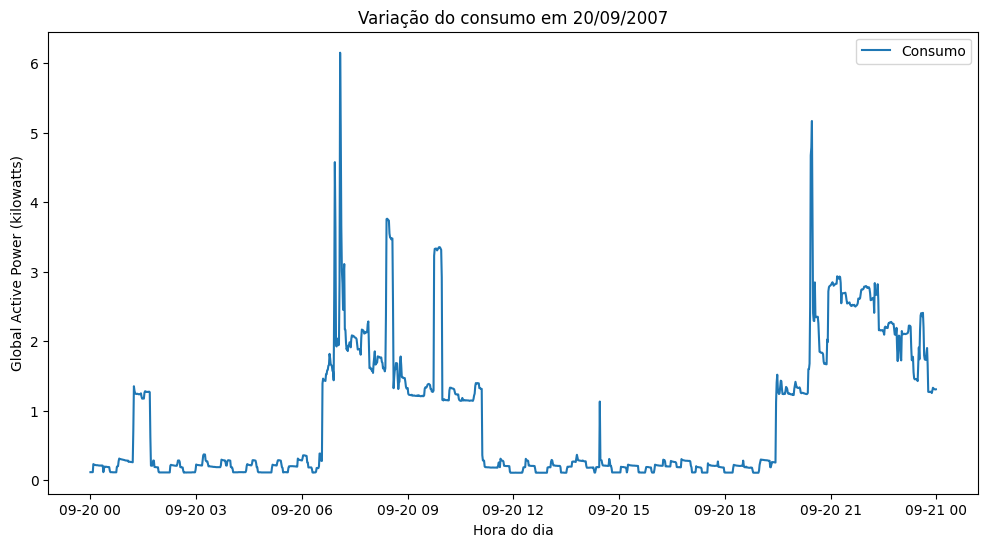

In [284]:
df_dia = dados_2007[dados_2007['Date'].dt.date == pd.to_datetime('2007-09-20').date()]

plt.figure(figsize=(12,6))
plt.plot(df_dia['Date'], df_dia['Global_active_power'], label='Consumo')
plt.xlabel("Hora do dia")
plt.ylabel("Global Active Power (kilowatts)")
plt.title("Variação do consumo em 20/09/2007")
plt.legend()
plt.show()

# 7 - Crie um histograma da variável Voltage. O que pode ser observado sobre sua distribuição?

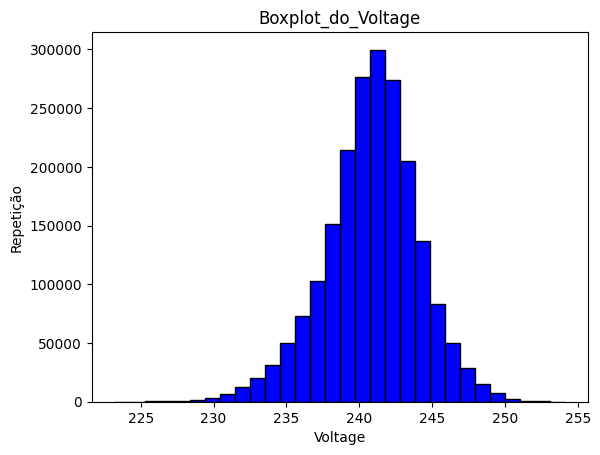

Ao analisar o grafico podemos observar que a maior parte dos valores de tensão está concentrada em torno de uma média central.


In [285]:
df['Voltage'] = pd.to_numeric(df["Voltage"], errors="coerce")
plt.hist(df['Voltage'], bins=30, color='blue', edgecolor='black')
plt.title('Boxplot_do_Voltage')
plt.xlabel('Voltage')
plt.ylabel('Repetição')
plt.show()

print('Ao analisar o grafico podemos observar que a maior parte dos valores de tensão está concentrada em torno de uma média central.')

# 8 - Calcule o consumo médio por mês em todo o período disponível no dataset.

In [286]:
ano = []
meses = []

registro_por_mes = 43200
for i in range (48):
    inicio = i * registro_por_mes
    fim = inicio + registro_por_mes
    if fim > len(df):
      fim = len(df)
    mes = df['Global_active_power'][inicio:fim]

    media_mes = np.mean(mes)
    meses.append(media_mes)

    media_ano = np.mean(meses)
print(f'A média do consumo de energia por mês em todo período do dataset é de: {media_ano}')

A média do consumo de energia por mês em todo período do dataset é de: 1.0888993885478406


# 9 - Identifique o dia com maior consumo de energia ativa global (Global_active_power)

In [287]:
gap = df['Global_active_power']
maior = max(gap)
posicao = df['Global_active_power'].idxmax()
dia_maior = df['Date'][posicao]
print(f'O dia com maior consumo de energia ativa global foi em: {dia_maior}')

O dia com maior consumo de energia ativa global foi em: 2009-02-22 17:09:00


# 10 - Compare o consumo médio de energia ativa global em dias de semana versus finais de semana.

In [288]:
'''
Identificando se o dia é um final de semana ou não (função 'weekday' retorna um valor
de 0 a 6, cada um equivalente a um dia da semana onde e 5 e 6 são sábado e domingo respectivamente)
'''

fds = df[df['Date'].dt.weekday >= 5]
semana = df[df['Date'].dt.weekday < 5]

#calculando o valor total e a quantidade de valores nos dias da semana e finais de semana
soma_semana = semana['Global_active_power'].sum()
contagem_semana = semana['Global_active_power'].count()
soma_fds = fds['Global_active_power'].sum()
contagem_fds = fds['Global_active_power'].count()

In [289]:
#Calculando o consumo médio de energia ativa global durante finais de semana e dias de semana

media = soma_fds / contagem_fds
print(f"A media da energia ativa global durante os finais de semana é de: {media:.3f}")

mediaS = soma_semana / contagem_semana
print(f"A media da energia ativa global durante a semana é de: {mediaS:.3f}")

A media da energia ativa global durante os finais de semana é de: 1.234
A media da energia ativa global durante a semana é de: 1.035


In [290]:
#Comparando as médias e imprimindo suas diferenças

if media > mediaS:
  print(f"O consumo médio de energia ativa global é maior durante os finais de semana, sendo aproximadamente {media - mediaS:.3f}Kw a mais")
else:
  print(f"O consumo médio de energia ativa global é maior durante os dias de semana, sendo aproximadamente {mediaS - media:.3f}Kw a mais")

O consumo médio de energia ativa global é maior durante os finais de semana, sendo aproximadamente 0.199Kw a mais


# 11 - Calcule a correlação entre as variáveis Global_active_power, Global_reactive_power, Voltage e Global_instensity.

In [291]:
#Transformando as colunas 'Global_reactive_power', 'Voltage' e 'Global_Intensity' em valores numericos

df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'], errors='coerce')
df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce')
df['Global_intensity'] = pd.to_numeric(df['Global_intensity'], errors='coerce')

#Usando a função 'corr()' para calcular a correlação entre as quatro colunas
correlacao = df[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']].corr()
print(correlacao)

                       Global_active_power  Global_reactive_power   Voltage  \
Global_active_power               1.000000               0.247017 -0.399762   
Global_reactive_power             0.247017               1.000000 -0.112246   
Voltage                          -0.399762              -0.112246  1.000000   
Global_intensity                  0.998889               0.266120 -0.411363   

                       Global_intensity  
Global_active_power            0.998889  
Global_reactive_power          0.266120  
Voltage                       -0.411363  
Global_intensity               1.000000  


# 12 - Crie uma nova variável chamada Total_Sub_metering que some Sub_metering_1, Sub_metering_2 e Sub_metering_3.

In [292]:
#Transformando as colunas 'Sub_metering_1', 'Sub_metering_2' e 'Sub_metering_3' em valores numericos

df['Sub_metering_1'] = pd.to_numeric(df['Sub_metering_1'], errors='coerce')
df['Sub_metering_2'] = pd.to_numeric(df['Sub_metering_2'], errors='coerce')
df['Sub_metering_3'] = pd.to_numeric(df['Sub_metering_3'], errors='coerce')

#Somando os valores das 3 colunas em uma nova coluna chamada 'Total_Sub_metering'
df['Total_Sub_metering'] = df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3']

df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Dia_Da_Semana,Total_Sub_metering
0,2006-12-16 17:24:00,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,Saturday,18.0
1,2006-12-16 17:25:00,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,Saturday,17.0
2,2006-12-16 17:26:00,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,Saturday,19.0
3,2006-12-16 17:27:00,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,Saturday,18.0
4,2006-12-16 17:28:00,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,Saturday,18.0


# 13 - Verifique se há algum mês em que Total_Sub_metering ultrapassa a média de Global_active_power

In [293]:
#identificando as colunas 'Global_active_power' e 'Total_Sub_metering'
numerical_cols = ['Global_active_power', 'Total_Sub_metering']

for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df_scaled = df.dropna(subset=numerical_cols).copy()

#normalizando os valores de 'Global_active_power' e 'Total_Sub_metering'
scaler = MinMaxScaler()

df_scaled[numerical_cols] = scaler.fit_transform(df_scaled[numerical_cols])

#Calculando as médias das colunas por mês
mesTSM = df_scaled.groupby(df_scaled['Date'].dt.to_period('M'))['Total_Sub_metering'].mean()
mesGAP = df_scaled.groupby(df_scaled['Date'].dt.to_period('M'))['Global_active_power'].mean()

#Comparando qual média é maior por mês
comparar = pd.DataFrame({'Total_Sub_metering_media': mesTSM,'Global_active_power_media': mesGAP})

maiorTSM = comparar[comparar['Total_Sub_metering_media'] > comparar['Global_active_power_media']]
maiorGAP = comparar[comparar['Global_active_power_media'] > comparar['Total_Sub_metering_media']]


#Caso 'Total_Sub_metering' possua médias maiores, será contabilizado quantas vezes isso ocorre e imprimir a quantidade final
if maiorTSM.empty == False:
  numMaiorTSM = []
  for index, row in maiorTSM.iterrows():
      numMaiorTSM.append(index)

  print(f'Quantidade de meses em que o "Total Sub metering" foi maior: {numMaiorTSM}')
  print(maiorTSM)

#Caso 'Global_Active_Power' possua médias maiores em todos os meses
else:
  print('Não há mês algum em que o "Total Sub metering" foi maior que a média de "Global Active Power"')
  print(' ')
  print(maiorGAP)


Não há mês algum em que o "Total Sub metering" foi maior que a média de "Global Active Power"
 
         Total_Sub_metering_media  Global_active_power_media
Date                                                        
2006-12                  0.081143                   0.165245
2007-01                  0.077787                   0.133083
2007-02                  0.070792                   0.119960
2007-03                  0.076215                   0.112496
2007-04                  0.051040                   0.073799
2007-05                  0.063078                   0.082370
2007-06                  0.055068                   0.067972
2007-07                  0.042520                   0.053537
2007-08                  0.052085                   0.062302
2007-09                  0.061241                   0.080873
2007-10                  0.064735                   0.093057
2007-11                  0.073279                   0.110309
2007-12                  0.086840                 

# 14 - Faça um gráfico de série temporal de Voltage para o ano de 2008.

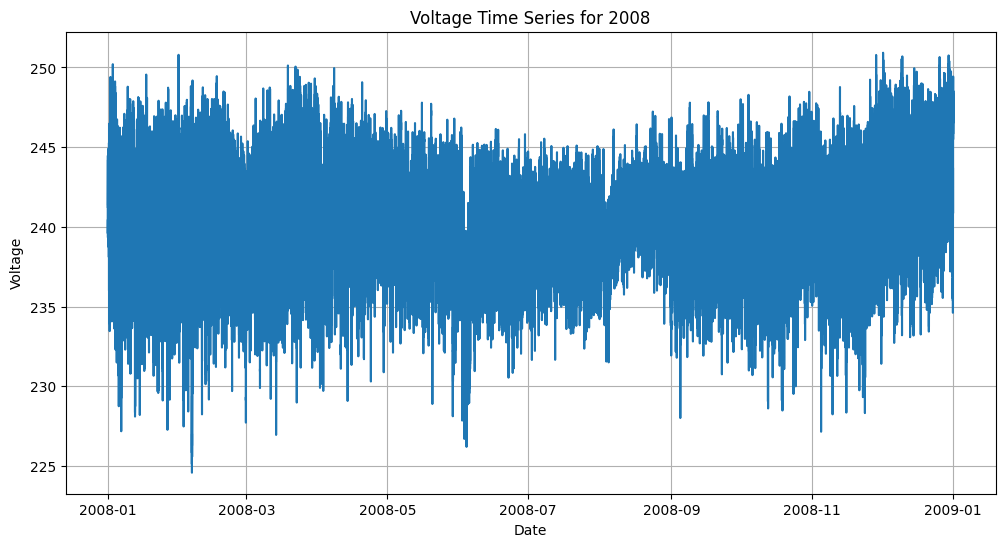

In [294]:
# Filtra o ano de 2008
df_2008 = df[df['Date'].dt.year == 2008].copy()

# Indexa o datatime para servir de chave para o plot do grafico
df_2008.set_index('Date', inplace=True)

# Converte os numeros de "Voltage" de string para numeros
df_2008['Voltage'] = pd.to_numeric(df_2008['Voltage'], errors='coerce')

# Dropa a coluna "Voltage"
df_2008.dropna(subset=['Voltage'], inplace=True)

# Plota o grafico
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_2008, x=df_2008.index, y='Voltage')
plt.title('Voltage Time Series for 2008')
plt.xlabel('Date')
plt.ylabel('Voltage')
plt.grid(True)
plt.show()

# 15 - Compare o consumo entre os meses de verão e inverno (no hemisfério norte)

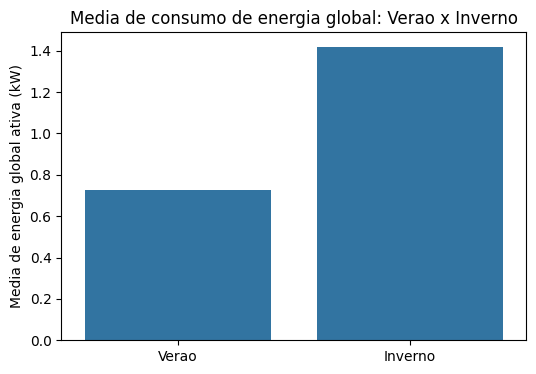

Media de consumo global no Verao: 0.73 kW
Media de consumo global no Inverno: 1.42 kW


In [295]:
# Define os meses de verao e inverno no hemisferio norte
summer_months = [6, 7, 8]
winter_months = [12, 1, 2]

# Filtra a data para meses de verao e inverno
df_summer = df[df['Date'].dt.month.isin(summer_months)].copy()
df_winter = df[df['Date'].dt.month.isin(winter_months)].copy()

# Converte 'Global_active_power' para variavel numerica
df_summer['Global_active_power'] = pd.to_numeric(df_summer['Global_active_power'], errors='coerce')
df_winter['Global_active_power'] = pd.to_numeric(df_winter['Global_active_power'], errors='coerce')

# Calcula a media entre o consumo do verao e do inverno
average_power_summer = df_summer['Global_active_power'].mean()
average_power_winter = df_winter['Global_active_power'].mean()

# Cria grafico de barras para comparar as medias de consumo
labels = ['Verao', 'Inverno']
averages = [average_power_summer, average_power_winter]

plt.figure(figsize=(6, 4))
sns.barplot(x=labels, y=averages)
plt.title('Media de consumo de energia global: Verao x Inverno')
plt.ylabel('Media de energia global ativa (kW)')
plt.show()

print(f'Media de consumo global no Verao: {average_power_summer:.2f} kW')
print(f'Media de consumo global no Inverno: {average_power_winter:.2f} kW')

# 16 - Aplique uma amostragem aleatória de 1% dos dados e verifique se a distribuição de Global_active_power é semelhante à da base completa

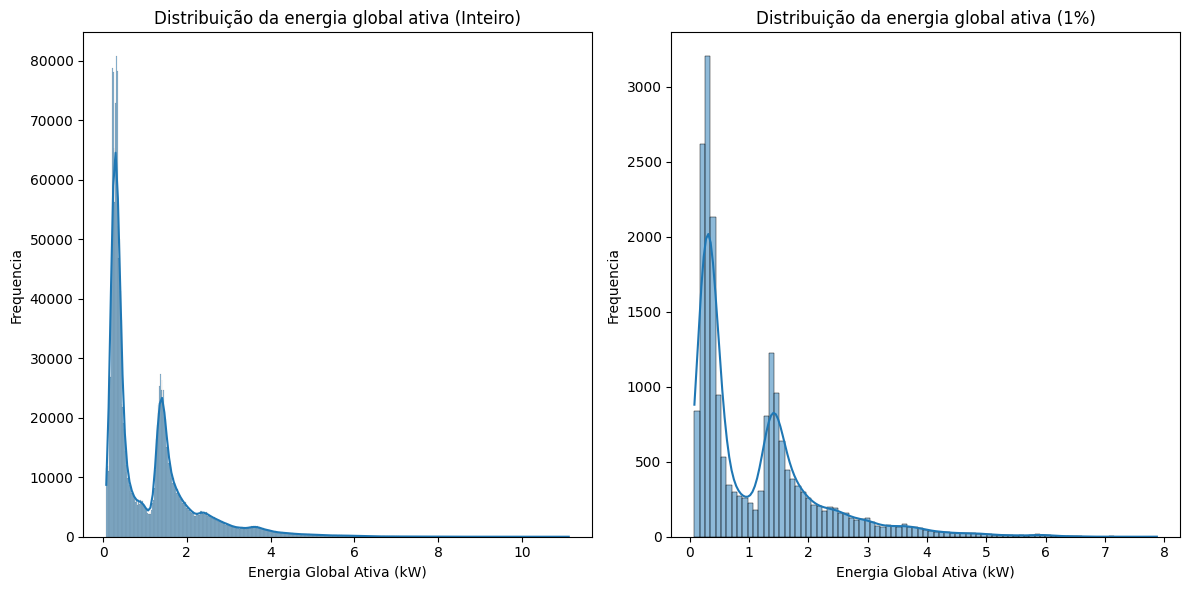

In [296]:
# Pega 1% do data aleatoriamente
df_sample = df.sample(frac=0.01, random_state=42).copy()

# Converte o 'Global_active_power' para numero para o data inteiro e para o 1%
df_sample['Global_active_power'] = pd.to_numeric(df_sample['Global_active_power'], errors='coerce')

# Dropa valores nulos em ambos os datas
df_full_power = df.dropna(subset=['Global_active_power'])
df_sample_power = df_sample.dropna(subset=['Global_active_power'])

# Plota o histograma
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_full_power['Global_active_power'], kde=True)
plt.title('Distribuição da energia global ativa (Inteiro)')
plt.xlabel('Energia Global Ativa (kW)')
plt.ylabel('Frequencia')

plt.subplot(1, 2, 2)
sns.histplot(df_sample_power['Global_active_power'], kde=True)
plt.title('Distribuição da energia global ativa (1%)')
plt.xlabel('Energia Global Ativa (kW)')
plt.ylabel('Frequencia')

plt.tight_layout()
plt.show()

# 17 - Utilize uma técnica de normalização (Min-Max Scaling) para padronizar as variáveis numéricas principais.

In [297]:
from sklearn.preprocessing import MinMaxScaler

# Indentifica a coluna numerica principal para escala
numerical_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

# Converte essas colunas para numericos
for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Dropa colunas com valores nulos dentro das colunas numericas pós converção
df_scaled = df.dropna(subset=numerical_cols).copy()

# Aplica o Minimo-Maximo dentro das colunas numericas
df_scaled[numerical_cols] = scaler.fit_transform(df_scaled[numerical_cols])

# Mostra
display(df_scaled.head())

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Dia_Da_Semana,Total_Sub_metering
0,2006-12-16 17:24:00,17:24:00,0.374796,0.300719,0.376090,0.377593,0.0,0.0125,0.548387,Saturday,18.0
1,2006-12-16 17:25:00,17:25:00,0.478363,0.313669,0.336995,0.473029,0.0,0.0125,0.516129,Saturday,17.0
2,2006-12-16 17:26:00,17:26:00,0.479631,0.358273,0.326010,0.473029,0.0,0.0250,0.548387,Saturday,19.0
3,2006-12-16 17:27:00,17:27:00,0.480898,0.361151,0.340549,0.473029,0.0,0.0125,0.548387,Saturday,18.0
4,2006-12-16 17:28:00,17:28:00,0.325005,0.379856,0.403231,0.323651,0.0,0.0125,0.548387,Saturday,18.0


# 18 - Aplique K-means para segmentar os dias em 3 grupos distintos de consumo elétrico. Interprete os resultados


In [298]:
# Importando os pacotes:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

In [299]:
# Load the correct dataset
df = pd.read_csv('/content/individual+household+electric+power+consumption.zip', sep=';', low_memory=False)

In [300]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [301]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [302]:
df.columns

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [303]:
# Criando novo dataframe apenas com as colunas 'Annual Income (k$)',' Spending Score (1-100)'
df1 = df.iloc[:,3:]
df1.head()

,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,0.418,234.840,18.400,0.000,1.000,17.0
1,0.436,233.630,23.000,0.000,1.000,16.0
2,0.498,233.290,23.000,0.000,2.000,17.0
3,0.502,233.740,23.000,0.000,1.000,17.0
4,0.528,235.680,15.800,0.000,1.000,17.0


In [304]:
df1.replace('?', np.nan, inplace=True)
df1 = df1.apply(pd.to_numeric, errors='coerce')
df1.fillna(df1.mean(), inplace=True)


distorcoes = []
K = range(1,10)
for k in K:
    modelo01 = KMeans(n_clusters=k)
    modelo01.fit(df1)
    distorcoes.append(modelo01.inertia_)

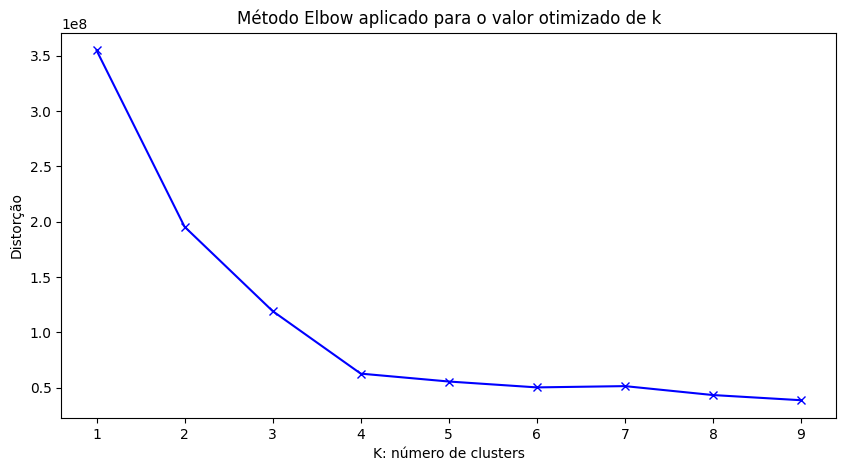

In [305]:
plt.figure(figsize=(10,5))
plt.plot(K, distorcoes, '-bx')

# Define os labels do eixos do gráfico:
plt.xlabel('K: número de clusters')
plt.ylabel('Distorção')

# Define um título para o gráfico:
plt.title('Método Elbow aplicado para o valor otimizado de k')

# Mostra o gráfico:
plt.show()

In [306]:
modeloEx = KMeans(n_clusters=5)
modeloEx.fit(df1)

KMeans(n_clusters=5)

In [307]:
# A partir do modelo treinado, fazemos as predições dos clusters e criamos uma coluna chamada "k_means"
df1['clusters'] = modeloEx.predict(df1)

In [308]:
df3 = df1.sample(frac=0.005)

In [309]:
df3.shape

(10376, 7)

In [310]:
sil_score = silhouette_score(df3, df3['clusters'])
print(f"Silhouette score: {sil_score:.4f}")

Silhouette score: 0.7174


# 19 - Realize uma decomposição de série temporal (tendência, sazonalidade e resíduo) para Global_active_power em um período de 6 meses.

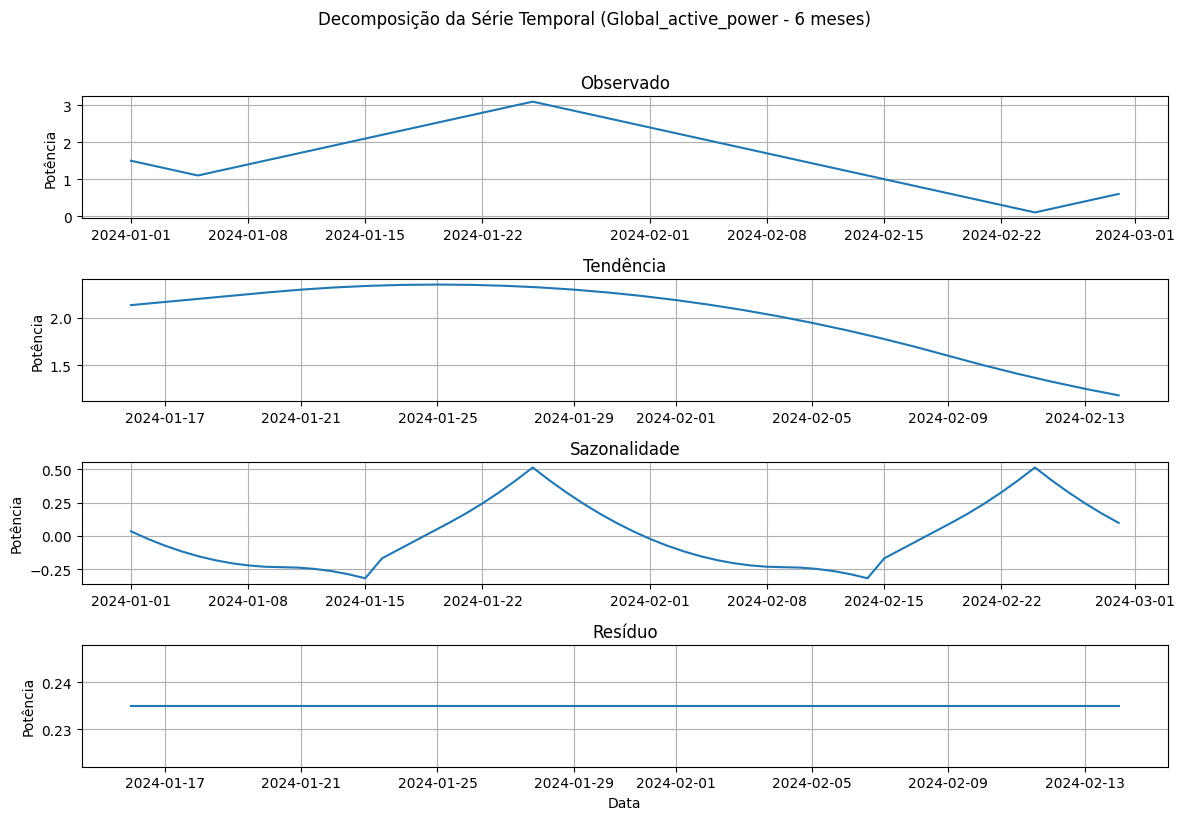

In [311]:

from statsmodels.tsa.seasonal import seasonal_decompose

# Dados de exemplo
df = {'Global_active_power': [1.5, 1.4, 1.3, 1.2, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8,
                              1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0,
                              3.1, 3.0, 2.9, 2.8, 2.7, 2.6, 2.5, 2.4, 2.3, 2.2, 2.1, 2.0,
                              1.9, 1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8,
                              0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]}
index = pd.date_range(start='2024-01-01', periods=60, freq='D')
df = pd.DataFrame(df, index=index)

# 2. Decomposição da série temporal
result = seasonal_decompose(df['Global_active_power'], model='additive', period=30)

# 3. Plotagem dos resultados
plt.figure(figsize=(12, 8))
plt.suptitle('Decomposição da Série Temporal (Global_active_power - 6 meses)', y=1.02)

# Série Observada
plt.subplot(4, 1, 1)
plt.plot(result.observed)
plt.title('Observado')
plt.grid(True)
plt.ylabel('Potência')

# Tendência
plt.subplot(4, 1, 2)
plt.plot(result.trend)
plt.title('Tendência')
plt.grid(True)
plt.ylabel('Potência')

# Sazonalidade
plt.subplot(4, 1, 3)
plt.plot(result.seasonal)
plt.title('Sazonalidade')
plt.grid(True)
plt.ylabel('Potência')

# Resíduo
plt.subplot(4, 1, 4)
plt.plot(result.resid)
plt.title('Resíduo')
plt.grid(True)
plt.ylabel('Potência')
plt.xlabel('Data')

plt.tight_layout()
plt.show()


# 20 - Treine um modelo de regressão linear simples para prever Global_active_power a partir de Global_intensity. Avalie o erro do modelo.

O R-squared (R²) do modelo é: 0.9729
O Mean Squared Error (MSE) do modelo é: 0.2555
---
Coeficiente angular (Slope): 0.4994
Intercepto: -0.0454


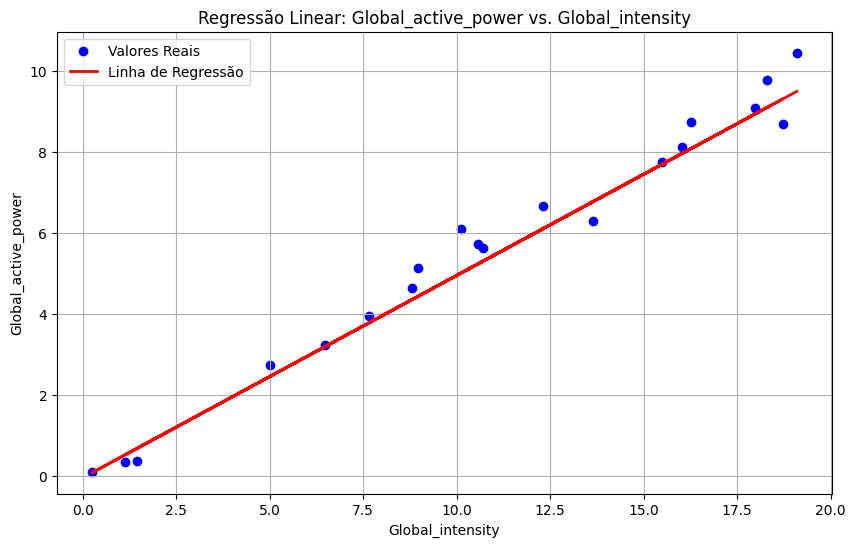

In [312]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# 1. Preparar os dados
# Assumindo que seu DataFrame 'df' já está carregado e tratado.
# Se precisar, substitua esta parte com seu código de carregamento e limpeza de dados.
# Certifique-se de que os dados são numéricos.
# Exemplo de dados:
df = pd.DataFrame({
    'Global_intensity': np.random.rand(100) * 20,  # Valores aleatórios para a demonstração
    'Global_active_power': np.random.rand(100) * 10 + 0.5 # Valores aleatórios
})
# Ajustando a relação para que seja visível no gráfico
df['Global_active_power'] = 0.5 * df['Global_intensity'] + np.random.randn(100) * 0.5


# Define a variável independente (X) e a dependente (y)
X = df[['Global_intensity']]
y = df['Global_active_power']


# 2. Dividir os dados em conjuntos de treino e teste
# Isso é uma boa prática para avaliar o modelo em dados que ele nunca viu.
# 80% para treino, 20% para teste.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 3. Treinar o modelo de regressão linear
modelo_regressao = LinearRegression()
modelo_regressao.fit(X_train, y_train)


# 4. Fazer previsões no conjunto de teste
y_pred = modelo_regressao.predict(X_test)


# 5. Avaliar o erro do modelo
# Mean Squared Error (MSE): A média dos quadrados dos erros. Valor menor é melhor.
mse = mean_squared_error(y_test, y_pred)
# R-squared (R2): Proporção da variância da variável dependente que é explicada pelo modelo.
# Varia de 0 a 1. Quanto mais próximo de 1, melhor o ajuste do modelo.
r2 = r2_score(y_test, y_pred)


print(f"O R-squared (R²) do modelo é: {r2:.4f}")
print(f"O Mean Squared Error (MSE) do modelo é: {mse:.4f}")
print("---")
print(f"Coeficiente angular (Slope): {modelo_regressao.coef_[0]:.4f}")
print(f"Intercepto: {modelo_regressao.intercept_:.4f}")


# 6. Visualizar a linha de regressão
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Valores Reais')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Linha de Regressão')
plt.title('Regressão Linear: Global_active_power vs. Global_intensity')
plt.xlabel('Global_intensity')
plt.ylabel('Global_active_power')
plt.legend()
plt.grid(True)
plt.show()

# 21. Séries temporais por hora
- Converta Date e Time em índice datetime.
- Reamostre os dados em intervalos de 1 hora, calculando a média de Global_active_power.
- Identifique os horários de maior consumo médio ao longo do dia.
Observação: uma série temporal é um conjunto de dados registrados em ordem cronológica, útil
para identificar padrões de comportamento ao longo do tempo.

In [313]:
# Combina as colunas Data e Time em uma unica DataTime e as indexa
df_original = pd.read_csv('/content/individual+household+electric+power+consumption.zip', sep=';', low_memory=False)
df_original['DateTime'] = pd.to_datetime(df_original['Date'] + ' ' + df_original['Time'], dayfirst=True)
df_original.set_index('DateTime', inplace=True)

# Converte para numerico
df_original['Global_active_power'] = pd.to_numeric(df_original['Global_active_power'], errors='coerce')

# Dropa valores nulos
df_original.dropna(subset=['Global_active_power'], inplace=True)

# Reamostre os dados em intervalos de 1 hora, calculando a média de Global_active_power
df_hourly = df_original['Global_active_power'].resample('H').mean()

# Identifique os horários de maior consumo médio ao longo do dia
hourly_average = df_hourly.groupby(df_hourly.index.hour).mean()
peak_hours = hourly_average.sort_values(ascending=False)

print("Horários de maior consumo médio ao longo do dia:")
print(peak_hours)

Horários de maior consumo médio ao longo do dia:
DateTime
20    1.899073
21    1.876063
19    1.733428
7     1.502373
8     1.460940
22    1.412681
9     1.331642
18    1.326433
10    1.260913
11    1.246408
12    1.207061
13    1.144471
14    1.082750
17    1.056164
15    0.990806
16    0.948805
23    0.902142
6     0.791606
0     0.659562
1     0.539325
2     0.480618
5     0.453674
3     0.444850
4     0.443844
Name: Global_active_power, dtype: float64


# 22. Autocorrelação do consumo
- Use a série temporal de Global_active_power.
- Calcule a autocorrelação em lags de 1h, 24h e 48h.
- Pergunta: existem padrões repetidos diariamente?

In [314]:
# Reamostrar por hora
df_hourly = df_original["Global_active_power"].resample("h").mean()

# Calcular autocorrelação com lag de 1h, 24h, 48h
autocorr_1h = df_hourly.autocorr(lag=1)
autocorr_24h = df_hourly.autocorr(lag=24)
autocorr_48h = df_hourly.autocorr(lag=48)

print(f"Autocorrelação (lag=1h): {autocorr_1h:.3f}")
print(f"Autocorrelação (lag=24h): {autocorr_24h:.3f}")
print(f"Autocorrelação (lag=48h): {autocorr_48h:.3f}")

Autocorrelação (lag=1h): 0.713
Autocorrelação (lag=24h): 0.436
Autocorrelação (lag=48h): 0.401


Os padrões se repetem diariamente, conforme os hábitos dos moradores. Por exemplo, ao longo do dia, há uma queda no consumo de energia de madrugada, picos na hora do café, almoço e jantar, e um aumento quando escurece

# 23. Redução de dimensionalidade com PCA
- Selecione Global_active_power, Global_reactive_power, Voltage e Global_intensity.
- Aplique PCA para reduzir para 2 componentes principais.
- Analise a variância explicada por cada componente.

In [315]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Converter variáveis numéricas
cols = ["Global_active_power", "Global_reactive_power", "Voltage", "Global_intensity"]

df_pca = df_original[cols].dropna()

# --- Padronizar os dados ---
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)

# --- PCA para 2 componentes ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_scaled)

explained_variance = pca.explained_variance_ratio_

print("Variância explicada por cada componente:")
print(f"PC1: {explained_variance[0]*100:.2f}%")
print(f"PC2: {explained_variance[1]*100:.2f}%")
print(f"Total (PC1+PC2): {explained_variance.sum()*100:.2f}%")

Variância explicada por cada componente:
PC1: 59.10%
PC2: 22.72%
Total (PC1+PC2): 81.82%


O primeiro componente capta a maior parte da variância, já que relaciona Global_active_power e Global_reactive_power, que são dois dados altamente correlacionados. Já o segundo componente contribui bem menos, captando a relação entre Voltage e Global_intensity. Ambos componentes contribuem com quase 82%, representando que a redução de dimensão é eficiente.

# 24. Visualização de clusters no espaço PCA
- Combine os resultados do PCA com K-Means (3 clusters).
- Plote os pontos resultantes e pinte cada grupo por cluster.
- Pergunta: os grupos se separam de forma clara?

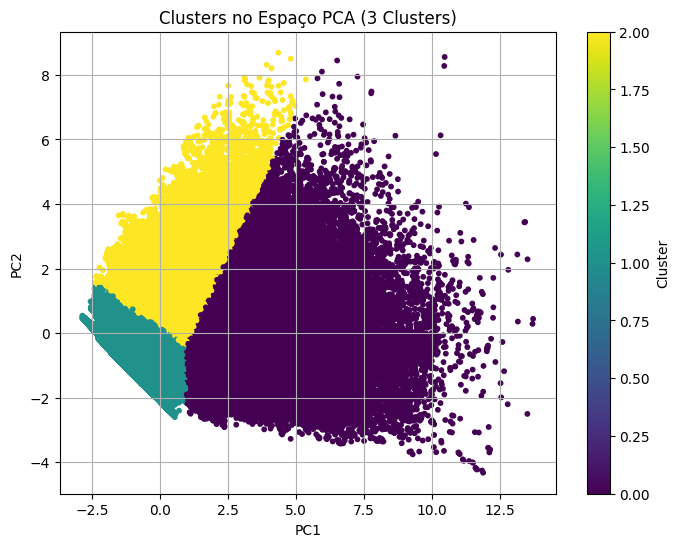


Análise da separação dos grupos:
Observe o gráfico acima. Se os pontos de cores diferentes estiverem bem separados, os grupos se se separam de forma clara.


In [316]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Apply KMeans with 3 clusters to the PCA results
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
clusters = kmeans.fit_predict(X_pca)

# Add the cluster labels to the df_pca DataFrame
df_pca['cluster'] = clusters

# Create a DataFrame from the PCA results with column names
X_pca_df = pd.DataFrame(X_pca, index=df_pca.index, columns=['PC1', 'PC2'])

# Concatenate the PCA DataFrame with the df_pca DataFrame
df_pca = pd.concat([df_pca, X_pca_df], axis=1)

# Plot the clusters in the PCA space
plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['cluster'], cmap='viridis', s=10)
plt.title('Clusters no Espaço PCA (3 Clusters)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# Question: os grupos se separam de forma clara?
print("\nAnálise da separação dos grupos:")
print("Observe o gráfico acima. Se os pontos de cores diferentes estiverem bem separados, os grupos se se separam de forma clara.")

In [317]:
pca = PCA(n_components=1)
pca_components = pca.fit_transform(X)


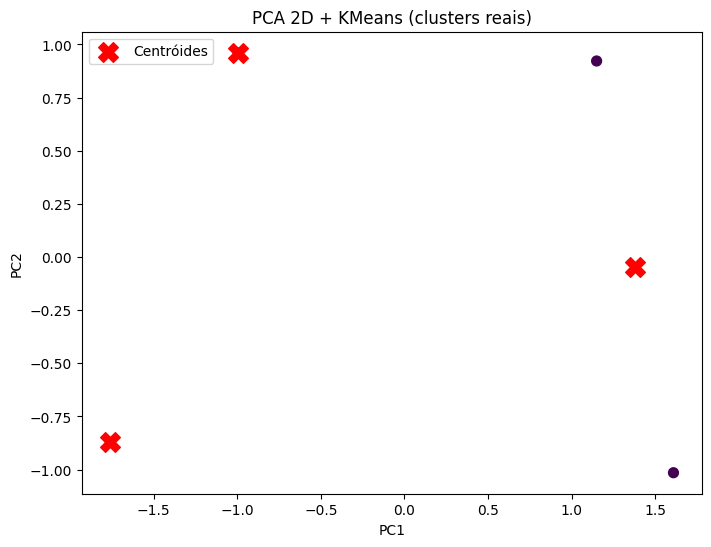

In [318]:
# --- Exemplo de DataFrame ---
# Substitua pelo seu dataset real
df = pd.DataFrame({
    "T1": [20, 21, 19, 22],
    "RH_1": [30, 35, 33, 32],
    "Appliances": [100, 120, 110, 130]
})

# --- Seleciona apenas as colunas numéricas ---
X = df.select_dtypes(include='number')

# --- Padroniza os dados ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- PCA (2 componentes para plot 2D real) ---
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

# --- KMeans (3 clusters) ---
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
labels = kmeans.fit_predict(pca_components)

# --- DataFrame para plot ---
df_plot = pd.DataFrame({
    "PC1": pca_components[:, 0],
    "PC2": pca_components[:, 1],
    "cluster": labels
})

# --- Plot 2D ---
plt.figure(figsize=(8,6))
plt.scatter(df_plot["PC1"], df_plot["PC2"], c=df_plot["cluster"], cmap="viridis", s=50)

# Centróides reais em 2D
centroids_2D = kmeans.cluster_centers_
plt.scatter(centroids_2D[:,0], centroids_2D[:,1], marker="X", s=200, c="red", label="Centróides")

plt.title("PCA 2D + KMeans (clusters reais)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


In [319]:
whos


Variable               Type                  Data/Info
------------------------------------------------------
K                      range                 range(1, 10)
KMeans                 ABCMeta               <class 'sklearn.cluster._kmeans.KMeans'>
LinearRegression       ABCMeta               <class 'sklearn.linear_mo<...>._base.LinearRegression'>
MinMaxScaler           type                  <class 'sklearn.preproces<...>sing._data.MinMaxScaler'>
PCA                    ABCMeta               <class 'sklearn.decomposition._pca.PCA'>
PolynomialFeatures     type                  <class 'sklearn.preproces<...>mial.PolynomialFeatures'>
StandardScaler         type                  <class 'sklearn.preproces<...>ng._data.StandardScaler'>
X                      DataFrame                T1  RH_1  Appliances\n<...>\n3  22    32         130
X_pca                  ndarray               2049280x2: 4098560 elems, type `float64`, 32788480 bytes (31.26953125 Mb)
X_pca_df               DataFrame    

# 25. Regressão polinomial vs linear
- Modele Global_active_power em função de Voltage.
- Compare Regressão Linear Simples com Regressão Polinomial (grau 2).
- Analise RMSE e a curva ajustada

RMSE (Linear): 0.972
RMSE (Polinomial grau 2): 0.967


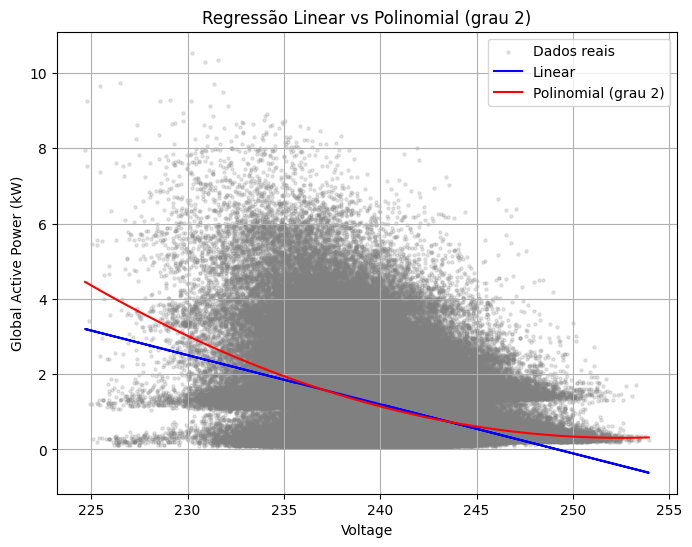

In [320]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

df = pd.read_csv('/content/individual+household+electric+power+consumption.zip', sep=';', low_memory=False)

df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce')

df_clean = df.dropna(subset=['Global_active_power', 'Voltage']).copy()

X = df_clean[['Voltage']]
y = df_clean['Global_active_power']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Regressão Linear ---
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))

# --- Regressão polinomial de grau 2---
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)
y_pred_poly = poly_reg.predict(X_test_poly)
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))

print(f"RMSE (Linear): {rmse_lin:.3f}")
print(f"RMSE (Polinomial grau 2): {rmse_poly:.3f}")


plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, alpha=0.2, label='Dados reais', s=5, color='gray')
plt.plot(X_test, y_pred_lin, color='blue', label='Linear')
X_test_sorted = X_test.sort_values(by='Voltage')
X_test_poly_sorted = poly_features.transform(X_test_sorted)
y_pred_poly_sorted = poly_reg.predict(X_test_poly_sorted)
plt.plot(X_test_sorted, y_pred_poly_sorted, color='red', label='Polinomial (grau 2)')


plt.xlabel('Voltage')
plt.ylabel('Global Active Power (kW)')
plt.title('Regressão Linear vs Polinomial (grau 2)')
plt.legend()
plt.grid(True)
plt.show()

# 26. Carregamento e inspeção inicial


In [321]:
df2 = pd.read_csv('/content/appliances+energy+prediction.zip', sep=',', low_memory=False)
df2.info()
df2.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,...,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,...,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,...,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,...,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,...,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,...,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,...,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


# 27. Distribuição do consumo

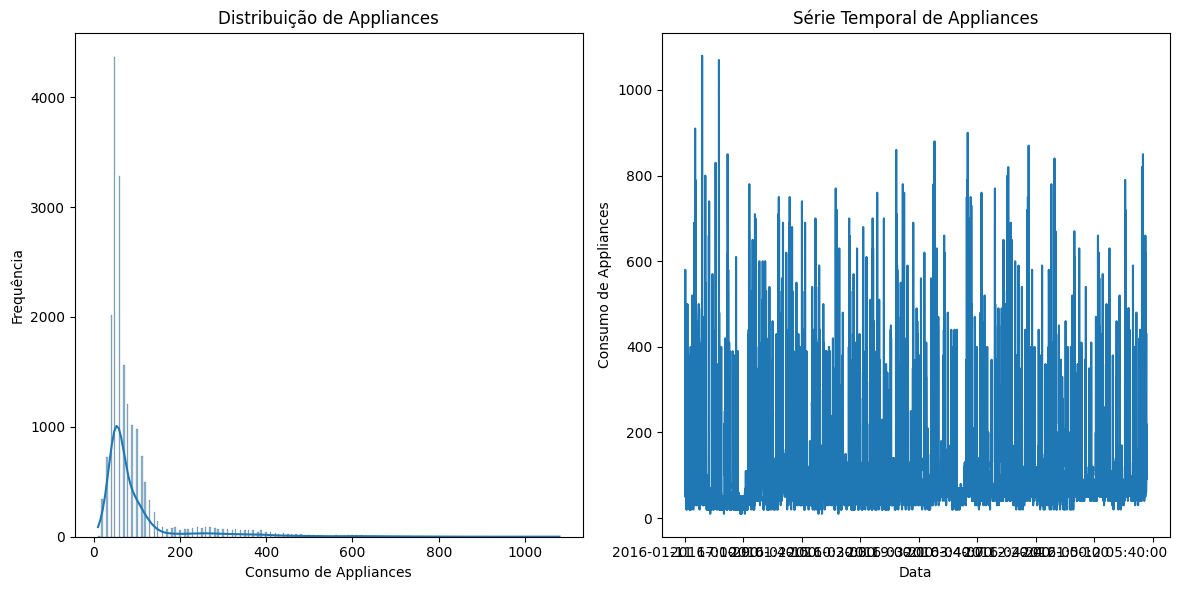

Ao analisar o gráfico de distribuição, podemos observar que o consumo tende a se concentrar em valores baixos.


In [322]:
# Plota o histograma
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df2['Appliances'], kde=True)
plt.title('Distribuição de Appliances')
plt.xlabel('Consumo de Appliances')
plt.ylabel('Frequência')

# Plora Série temporal
plt.subplot(1, 2, 2)
df2.set_index('date')['Appliances'].plot()
plt.title('Série Temporal de Appliances')
plt.xlabel('Data')
plt.ylabel('Consumo de Appliances')

plt.tight_layout()
plt.show()

print('Ao analisar o gráfico de distribuição, podemos observar que o consumo tende a se concentrar em valores baixos.')

# 28. Correlações com variáveis ambientes

In [323]:
df2['Temperatura_Media_Interna_Total'] = (df2['T1'] + df2['T2'] + df2['T3'] + df2['T4'] + df2['T5'] + df2['T6'] + df2['T7'] + df2['T8'] + df2['T9']) / 9
df2['Umidade_Media_Interna_Total'] = (df2['RH_1'] + df2['RH_2'] + df2['RH_3'] + df2['RH_4'] + df2['RH_5'] + df2['RH_6'] + df2['RH_7'] + df2['RH_8'] + df2['RH_9']) / 9

Correlacao_Appliances = df2[['Appliances', 'Temperatura_Media_Interna_Total', 'Umidade_Media_Interna_Total', 'T_out', 'RH_out']].corr()
print(Correlacao_Appliances)
print("\nOs fatores com maior relação com o consumo são as temperaturas, visto que tanto as internas quanto as externas estão mais próximas de 1 do que a umidade(seja interna ou externa)")

                                 Appliances  Temperatura_Media_Interna_Total  \
Appliances                         1.000000                         0.078247   
Temperatura_Media_Interna_Total    0.078247                         1.000000   
Umidade_Media_Interna_Total       -0.060228                        -0.417091   
T_out                              0.099155                         0.849342   
RH_out                            -0.152282                        -0.471033   

                                 Umidade_Media_Interna_Total     T_out  \
Appliances                                         -0.060228  0.099155   
Temperatura_Media_Interna_Total                    -0.417091  0.849342   
Umidade_Media_Interna_Total                         1.000000 -0.266103   
T_out                                              -0.266103  1.000000   
RH_out                                              0.673724 -0.574197   

                                   RH_out  
Appliances                    

# 29. Normalização dos dados

In [324]:
# Converte a coluna 'date' para datatime
df2['date'] = pd.to_datetime(df2['date'])

# Indentifica colunas numericas excluindo a date
numerical_cols = df2.select_dtypes(include=np.number).columns

# Inicializa o scaler Minimo-Maximo
scaler = MinMaxScaler()

# Aplica o Minimo-Maximo dentro das colunas numericas
df2[numerical_cols] = scaler.fit_transform(df2[numerical_cols])

# Mostra
display(df2.head())

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,Temperatura_Media_Interna_Total,Umidade_Media_Interna_Total
0,2016-01-11 17:00:00,0.046729,0.428571,0.32735,0.566187,0.225345,0.684038,0.215188,0.746066,0.351351,...,0.372990,0.097674,0.894737,0.500000,0.953846,0.538462,0.265449,0.265449,0.223627,0.741729
1,2016-01-11 17:10:00,0.046729,0.428571,0.32735,0.541326,0.225345,0.682140,0.215188,0.748871,0.351351,...,0.369239,0.100000,0.894737,0.476190,0.894872,0.533937,0.372083,0.372083,0.222019,0.739080
2,2016-01-11 17:20:00,0.037383,0.428571,0.32735,0.530502,0.225345,0.679445,0.215188,0.755569,0.344745,...,0.365488,0.102326,0.894737,0.452381,0.835897,0.529412,0.572848,0.572848,0.217863,0.732788
3,2016-01-11 17:30:00,0.037383,0.571429,0.32735,0.524080,0.225345,0.678414,0.215188,0.758685,0.341441,...,0.361736,0.104651,0.894737,0.428571,0.776923,0.524887,0.908261,0.908261,0.214545,0.731073
4,2016-01-11 17:40:00,0.046729,0.571429,0.32735,0.531419,0.225345,0.676727,0.215188,0.758685,0.341441,...,0.357985,0.106977,0.894737,0.404762,0.717949,0.520362,0.201611,0.201611,0.214880,0.736090


## 30. PCA

In [325]:
#Selecionando os componentes importantes (dados de entrada)
X = df2.iloc[:, 2:30].values

#Selecionando os dados de saída
Y = df2.iloc[:, 2].values

#Normalizando os valores dos dados de entrada
X = scaler.fit_transform(X)

#Treinando o algoritmo
X_treino, X_teste, y_treino, y_teste = train_test_split(X, Y, test_size=0.20, random_state=10)
print("Shape do treino X: ")
print(X_treino.shape, X_teste.shape)

#Selecionando dois componentes principais
p = 2
pca = PCA(n_components=p)
X_treino_pca = pca.fit_transform(X_treino)
X_teste_pca = pca.transform(X_teste)

#aplicando PCA
total_variancia = pca.explained_variance_ratio_.sum()
print(f'\nO modelo PCA com {p} variáveis explica{100*(total_variancia): .2f} % dos dados de entrada')

Shape do treino X: 
(15788, 28) (3947, 28)

O modelo PCA com 2 variáveis explica 59.20 % dos dados de entrada


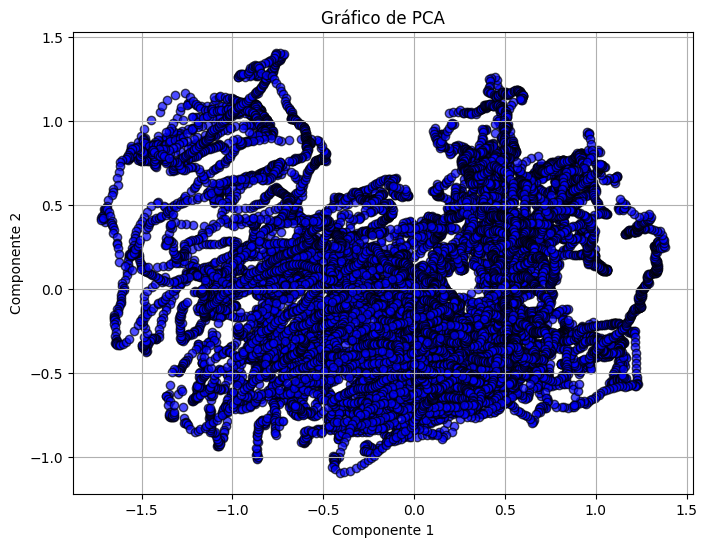

É possível notar que os valores se agrupam principalmente ao centro do gráfico


In [326]:
df2_numerical = df2.select_dtypes(include=np.number)

df2_scaled = scaler.fit_transform(df2_numerical)
df2_pca = pca.fit_transform(df2_scaled)
df2_pca_df = pd.DataFrame(df2_pca, columns=['PC1', 'PC2'])

#plotando gráfico
plt.figure(figsize=(8, 6))
plt.scatter(df2_pca_df['PC1'], df2_pca_df['PC2'], c='blue', edgecolors='k', alpha=0.7)
plt.title('Gráfico de PCA')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.grid(True)
plt.show()

#respondendo a pergunta:
print("É possível notar que os valores se agrupam principalmente ao centro do gráfico")

# 31. Regressão linear múltipla

In [327]:
variaveis_ambientais = [
    'T1','RH_1','T2','RH_2','T3','RH_3','T4','RH_4','T5','RH_5',
    'T6','RH_6','T7','RH_7','T8','RH_8','T9','RH_9',
    'T_out','Press_mm_hg','RH_out','Windspeed','Visibility','Tdewpoint'
]

X = df2[variaveis_ambientais]
y = df2['Appliances']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

modelo = LinearRegression()
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("R²:", r2)
print("Erro Médio Absoluto (MAE):", mae)

R²: 0.14920572345100924
Erro Médio Absoluto (MAE): 0.050129729589800845


# 32. Random Forest Regressor

In [328]:
# Convert the Sub_meterings columns to numeric
df[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']] = df[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].apply(pd.to_numeric, errors='coerce')

# Create the target variable Appliances
df['Appliances'] = df['Global_active_power'] * 1000 / 60 - df[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].sum(axis=1)

# Drop null values
df.dropna(subset=['Appliances'], inplace=True)

display(df.head())

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Appliances
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.400,0.0,1.0,17.0,52.266667
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.000,0.0,1.0,16.0,72.333333
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.000,0.0,2.0,17.0,70.566667
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.000,0.0,1.0,17.0,71.800000
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.800,0.0,1.0,17.0,43.100000


# 33. K-Means clustering

In [329]:
# Lista todas as colunas do dataset
print(df2.columns)

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2',
       'Temperatura_Media_Interna_Total', 'Umidade_Media_Interna_Total'],
      dtype='object')


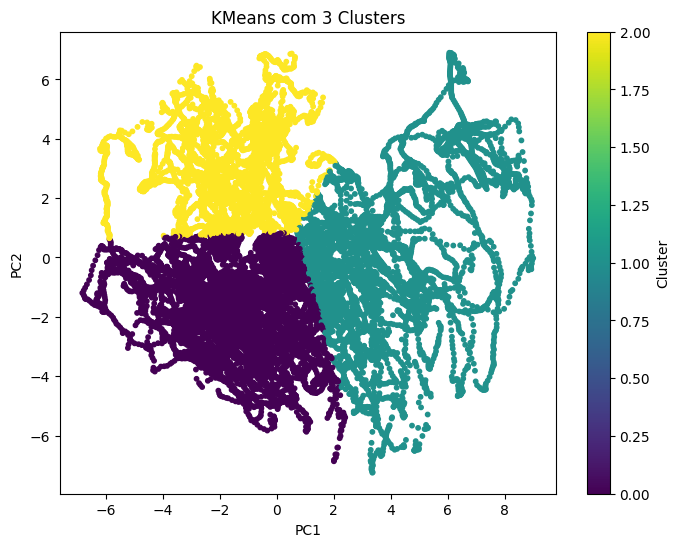

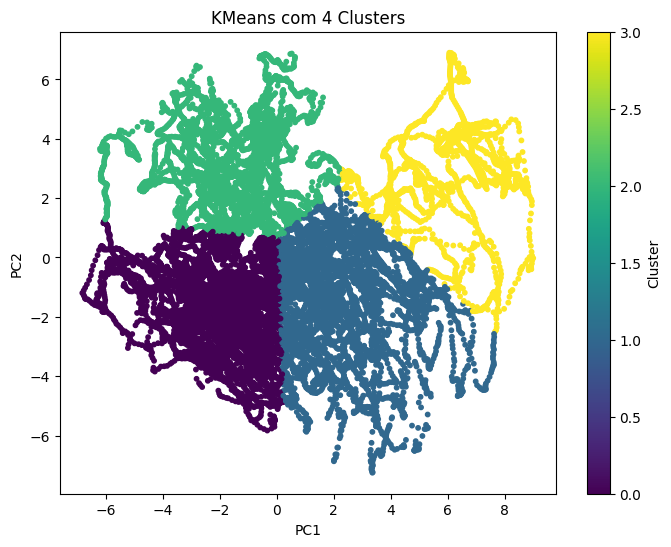

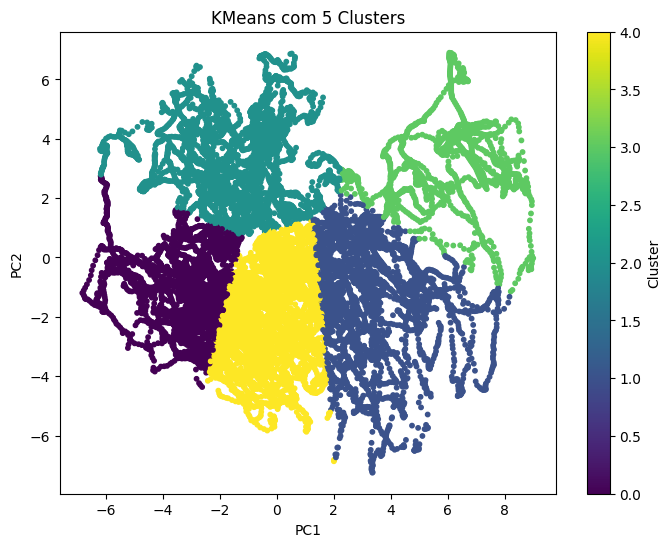

In [330]:
# --- Selecionar features relevantes ---
features = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9',
            'T_out', 'Press_mm_hg', 'RH_1', 'RH_2', 'RH_3', 'RH_4',
            'RH_5', 'RH_6', 'RH_7', 'RH_8', 'RH_9', 'RH_out', 'Windspeed',
            'Visibility', 'Tdewpoint']
X = df2[features]

# --- Padronização ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- PCA para 2 componentes ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# --- KMeans com 3 a 5 clusters ---
kmeans3 = KMeans(n_clusters=3, random_state=42, n_init="auto")
df2['cluster_3'] = kmeans3.fit_predict(X_pca)

kmeans4 = KMeans(n_clusters=4, random_state=42, n_init="auto")
df2['cluster_4'] = kmeans4.fit_predict(X_pca)

kmeans5 = KMeans(n_clusters=5, random_state=42, n_init="auto")
df2['cluster_5'] = kmeans5.fit_predict(X_pca)

# --- Perfis médios de consumo ---
profile_3 = df2.groupby('cluster_3')[features].mean()
profile_4 = df2.groupby('cluster_4')[features].mean()
profile_5 = df2.groupby('cluster_5')[features].mean()

# --- Visualização dos clusters ---
def plot_clusters(X_pca, labels, title):
    plt.figure(figsize=(8,6))
    plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='viridis', s=10)
    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.colorbar(label='Cluster')
    plt.show()

plot_clusters(X_pca, df2['cluster_3'], 'KMeans com 3 Clusters')
plot_clusters(X_pca, df2['cluster_4'], 'KMeans com 4 Clusters')
plot_clusters(X_pca, df2['cluster_5'], 'KMeans com 5 Clusters')


# 34. Classificação binária

In [331]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler


mediana = df2['Appliances'].median()
df2['Appliances_class'] = (df2['Appliances'] >= mediana).astype(int)

X = df2.drop(['Appliances', 'Appliances_class', 'date'], axis=1)
y = df2['Appliances_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)
y_pred_log = logreg.predict(X_test_scaled)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

print("Regressão Logística:")
print("Acurácia:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

print("\nRandom Forest:")
print("Acurácia:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Regressão Logística:
Acurácia: 0.7365309913865901
              precision    recall  f1-score   support

           0       0.66      0.62      0.64      2239
           1       0.78      0.81      0.79      3682

    accuracy                           0.74      5921
   macro avg       0.72      0.71      0.72      5921
weighted avg       0.73      0.74      0.73      5921


Random Forest:
Acurácia: 0.8203006248944436
              precision    recall  f1-score   support

           0       0.77      0.76      0.76      2239
           1       0.85      0.86      0.86      3682

    accuracy                           0.82      5921
   macro avg       0.81      0.81      0.81      5921
weighted avg       0.82      0.82      0.82      5921



# 35. Avaliação de classificação

In [332]:
# Dividir o consumo de Appliances em 3 categorias: baixo, médio, alto
df2['Appliances_class'] = pd.qcut(df2['Appliances'], q=3, labels=[0,1,2])


In [333]:
y_true = df2['Appliances_class']  # classes verdadeiras
y_pred = df2['cluster_3']         # clusters do KMeans


In [335]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from scipy.optimize import linear_sum_assignment
import pandas as pd

# Ajustar labels dos clusters para que correspondam melhor às classes
cm = confusion_matrix(y_true, y_pred)
row_ind, col_ind = linear_sum_assignment(-cm)  # maximiza correspondência
mapping = {col: row for row, col in zip(row_ind, col_ind)}
y_pred_mapped = y_pred.map(mapping)

# Matriz de confusão
cm_mapped = confusion_matrix(y_true, y_pred_mapped)
print("Matriz de Confusão:")
print(cm_mapped)

# Métricas
accuracy = accuracy_score(y_true, y_pred_mapped)
precision = precision_score(y_true, y_pred_mapped, average='macro')
recall = recall_score(y_true, y_pred_mapped, average='macro')
f1 = f1_score(y_true, y_pred_mapped, average='macro')

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Matriz de Confusão:
[[3832 1351 2279]
 [2768 2144 1135]
 [2586 2213 1427]]

Accuracy: 0.3751
Precision: 0.3625
Recall: 0.3658
F1 Score: 0.3610
